In [1213]:
from datetime import time, date

import pandas as pd
import numpy as np

from DataInterface.TrafficDataInterface import CityTrafficData, TrafficType, Service, ServiceType
from DataInterface.GeoDataInterface import GeoData, GeoDataType
from DataInterface.AdminDataInterface import AdminData
from DataInterface.ElectionDataInterface import ElectionData
from DataInterface.WeatherDataInterface import WeatherData
from Utils import City
from FeatureExtraction.SessionDistribution.SessionDistributionCalculator import SessionDistributionCalculator
from FeatureExtraction.SessionDistribution.SessionDistributionAPI import SessionDistributionAPI
from FeatureExtraction.IrisFeatureCalculator import IrisFeatureCalculator
from FeatureExtraction.ServiceConsumptionFeatureCalculator import ServiceConsumptionFeatureCalculator, ServiceConsumptionFeatureName
from FeatureExtraction.ElectionFeatureCalculator import ElectionFeatureCalculator, ElectionFeatureName, Party
from FeatureSelection.Regression import Regression

In [1137]:
%reload_ext autoreload

In [1133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA

In [ ]:
traffic_data = CityTrafficData(city=City.PARIS, geo_data_type=GeoDataType.IRIS, traffic_type=TrafficType.USERS)

In [ ]:
geo_data = GeoData()
geo_data.load(GeoDataType.IRIS)

In [1256]:
print(geo_data.geo_data[GeoDataType.IRIS.value].data.head()['geometry'].iloc[0])

POLYGON ((-4.324100574995778 48.093670892726045, -4.32439823513085 48.09361890463018, -4.32467807255901 48.093584293845396, -4.324908237740245 48.09357085299868, -4.3252699388462705 48.09354288731585, -4.325630395203716 48.093505960655826, -4.325805568826776 48.093485100730874, -4.325857355753608 48.09347916151795, -4.32593113253043 48.093466429133755, -4.326008921595405 48.09345344660087, -4.326303062608914 48.09336642685216, -4.326541342307396 48.09330457847347, -4.326640685964951 48.09330109674723, -4.327054109688786 48.09328616845357, -4.327714306879246 48.09328025414571, -4.328028820931557 48.093252510567815, -4.32827098885233 48.09322837341947, -4.328439971292872 48.09321151047739, -4.328657599072175 48.093195228925445, -4.3288236574441274 48.093176740260645, -4.328910650911562 48.093152336812246, -4.3295094503240135 48.09285019691452, -4.329893988169891 48.09266625148955, -4.3301006885513615 48.092581060010716, -4.330214705563935 48.09252785759022, -4.3303790736145436 48.0924389

In [ ]:
admin_data = AdminData()

In [567]:
weather_data = WeatherData()

# SLEEP DATA ANALSIS

In [392]:
session_distribution = SessionDistributionAPI.compute_session_distribution(traffic_data=(CityTrafficData(city=city, geo_data_type=GeoDataType.IRIS, traffic_type=TrafficType.USERS) for city in City))

100%|██████████| 77/77 [00:17<00:00,  4.46it/s]


In [393]:
session_distribution.distribution_plot()

In [394]:
session_distribution.time_change_discontinuity_plot()

In [893]:
session_expectation = session_distribution.expectation_by_location(timespan=(date(2019,4,15), None))

In [396]:
equip = admin_data.get_admin_data(coarsened_equip=False, selected_pop_vars=False)
equip = equip[[c for c in equip.columns if c.startswith('EQUIP')]]
session_expectation.correlation_plot(covariates=equip)

In [397]:
session_expectation.correlation_plot(covariates=admin_data.get_admin_data(coarsened_equip=False, selected_pop_vars=False))

In [533]:
session_expectation.geo_plot(geo_data=geo_data, normalize=True, remove_outliers=True)

In [534]:
session_expectation.scatter_plot(confidence_intervals=True)

In [535]:
iris_subset = session_expectation.data.index.values

In [536]:
iris_feature_constructor = IrisFeatureCalculator(admin_data=admin_data, geo_data=geo_data)

In [538]:
def log(df):
    vals = df.values
    log_vals = np.log(vals, out=np.zeros_like(vals), where=vals!=0)
    return pd.DataFrame(log_vals, index=df.index, columns=df.columns)

## City level analysis

In [696]:
city_data = [['Bordeaux', 1_190_000, 51, 220],
            ['Clermont-Ferrand', 490_000, 37, 200],
            ['Dijon', 407_000, 46, 115],
            ['Grenoble', 660_000, 45, 264],
            ['Lille', 1_472_000, 60, 1218],
            ['Lyon', 2_016_000, 50, 384],
            ['Mans', 347_397, 40,172],
            ['Marseille ', 1_248_000, 70, 553],
            ['Metz', 370_000, 44, 243],
            ['Montpellier', 686_000, 41, 350],
            ['Nancy', 506_000, 39, 184],
            ['Nantes', 922_000, 44, 285],
            ['Nice', 1_013_000, 64, 392],
            ['Orleans', 430_000, 45, 139],
            ['Paris', 12_794_000, 79, 732],
            ['Rennes', 672_000, 29, 195],
            ['Saint-Etienne', 475_000, 38, 308],
            ['Strasbourg', 805_000, 49, 358],
            ['Toulouse', 1_391_000, 42, 250],
            ['Tours', 508_000, 47, 155]]

city_stats = pd.DataFrame(data=city_data, columns=['city', 'population', 'share_of_pop_in_city', 'density'])
city_stats.set_index('city', inplace=True)

In [724]:
density_of_city = iris_feature_constructor.density_of_city(subset=iris_subset).data
density_of_city['density_of_city'] = log(density_of_city['density_of_city'].to_frame())

In [727]:
data = pd.merge(session_expectation.log_data(), density_of_city, left_index=True, right_index=True, how='inner')
data.dropna(inplace=True)
data_grouped_by_city = data.groupby(by=['city'])[['density_of_city', 'session_expectation']].median()

In [708]:
data_grouped_by_city = data.groupby(by=['city'])[['density_of_city', 'session_expectation']].median()
session_expectation_city = data_grouped_by_city['session_expectation'].to_frame()

In [698]:
data_city = pd.merge(session_expectation_city, city_stats, right_index=True, left_index=True, how='inner')
data_city['effective_population'] = data_city['population'] * data_city['share_of_pop_in_city'] / 100
data_city['population'] = log(data_city['population'].astype(float).to_frame())
data_city['density'] = log(data_city['density'].astype(float).to_frame())
data_city['effective_population'] = log(data_city['effective_population'].astype(float).to_frame())

In [671]:
sunrise_sunset_times = weather_data.get_sunrise_sunset_data(geo_data=geo_data, city=[c for c in City], aggregate=True)
sunrise_sunset_times['sunrise'] = weather_data.map_times_to_clockwise_distance_from_mid_night(times=sunrise_sunset_times['sunrise'])
sunrise_sunset_times['sunset'] = weather_data.map_times_to_clockwise_distance_from_mid_night(times=sunrise_sunset_times['sunset'])
sunrise_sunset_times

,sunrise,sunset
city,,
Bordeaux,7.016667,20.433333
Clermont-Ferrand,6.750000,20.216667
Dijon,6.583333,20.116667
Grenoble,6.583333,20.016667
Lille,6.616667,20.350000
Lyon,6.633333,20.100000
Mans,6.916667,19.866667
Marseille,6.650000,20.000000
Metz,6.450000,20.100000


In [721]:
data_reg = pd.merge(data_grouped_by_city, sunrise_sunset_times, right_index=True, left_index=True, how='inner')
data_reg

,density_of_city,session_expectation,sunrise,sunset
city,,,,
Bordeaux,-5.506718,2.136614,7.016667,20.433333
Clermont-Ferrand,-5.447219,2.099815,6.750000,20.216667
Dijon,-5.139118,2.107249,6.583333,20.116667
Grenoble,-5.000363,2.124896,6.583333,20.016667
Lille,-5.161260,2.137714,6.616667,20.350000
Lyon,-4.719418,2.126413,6.633333,20.100000
Mans,-5.389741,2.148895,6.916667,19.866667
Marseille,-4.649364,2.159814,6.650000,20.000000
Metz,-5.386065,2.133879,6.450000,20.100000


In [728]:
regression = Regression(features=data_grouped_by_city['density_of_city'].to_frame(), labels=data_grouped_by_city['session_expectation'].to_frame())
regression.plot()

### Variables considered

In [949]:
session_expectation = session_distribution.expectation_by_location()

In [950]:
def log(df):
    vals = df.values
    log_vals = np.log(vals, out=np.zeros_like(vals), where=vals!=0)
    return pd.DataFrame(log_vals, index=df.index, columns=df.columns)

In [951]:
density = iris_feature_constructor.var_density(subset=iris_subset, var_names=['P19_POP'])

In [952]:
education = iris_feature_constructor.var_density(subset=iris_subset, var_names=['P19_ACT_DIPLMIN', 'P19_ACT_SUP2', 'P19_ACT_SUP5'])

In [953]:
housing = iris_feature_constructor.var(subset=iris_subset, var_names=['C19_RP_HSTU1P_SUROCC'])

In [954]:
income = admin_data.get_admin_data(subset=iris_subset)[['DEC_MED19']]

In [955]:
age_density = iris_feature_constructor.var_density(subset=iris_subset, var_names=['P19_POP1529', 'P19_POP3044', 'P19_POP4559', 'P19_POP6074', 'P19_POP75P'])

In [956]:
nationality = iris_feature_constructor.var_density(subset=iris_subset, var_names=['P19_POP_IMM'])

In [957]:
occupations = iris_feature_constructor.var_density(subset=iris_subset, var_names=['C19_POP15P_CS6', 'P19_AINACT1564'])

In [1093]:
services = ['A1', 'A2', 'A5']
shops = ['B1', 'B2', 'B3']
schools = ['C1', 'C2', 'C3', 'C4' 'C5', 'C6']
health_care = ['D1', 'D2', 'D3', 'D4', 'D5']
transport = ['E1']
free_time = ['F1', 'F2', 'F3']
tourism = ['G1']

In [1]:
coarsened_equip = True
equip_names = [c for c in admin_data.get_admin_data(coarsened_equip=coarsened_equip).columns if c.startswith('EQUIP_')]
#equip_names = [c for c in equip_names if c.split('_')[1] in  transport + free_time + services]
business_index = iris_feature_constructor.var_density(subset=iris_subset, var_names=equip_names, coarsened_equip=coarsened_equip).sum(axis=1).to_frame('business_density')

NameError: name 'admin_data' is not defined

In [1290]:
# data = pd.merge(log(education), session_expectation.log_data(), left_index=True, right_index=True, how='inner')
data = pd.merge(session_expectation.log_data(), log(business_index), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(density), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(income), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(education), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(age_density), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(nationality), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(housing), left_index=True, right_index=True, how='inner')
#data = pd.merge(data, log(occupations), left_index=True, right_index=True, how='inner')
data = data[data != 0]
data.dropna(inplace=True)
data.shape, np.array(data.columns)

((6217, 2), array(['session_expectation', 'business_density'], dtype=object))

In [ ]:
features = data[[c for c in data.columns if c not in ['session_expectation']]]
# features = data[[x_axis]]
labels = data['session_expectation'].to_frame()
regression = Regression(features=features, labels=labels)
regression.plot()

In [964]:
admin_data_df = admin_data.get_admin_data(coarsened_equip=True, selected_pop_vars=False)
densities = iris_feature_constructor.var_density(subset=iris_subset, var_names=admin_data_df.columns, coarsened_equip=True)
session_expectation.correlation_plot(covariates=densities)

In [ ]:
iris_density_of_city = iris_feature_constructor.density_of_city(subset=iris_subset).data

In [ ]:
iris_pop_density = iris_feature_constructor.var_density(subset=iris_subset, var_names=['P19_POP']).rename(columns={'P19_POP': 'POP_DEN'})['POP_DEN']

In [ ]:
iris_business_density = iris_feature_constructor.business_density(subset=iris_subset).data

In [ ]:
age_shares = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_POP1529', 'P19_POP3044', 'P19_POP4559', 'P19_POP6074', 'P19_POP75P'])

In [ ]:
lonely_shares = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_POP15P_PSEUL'])

In [ ]:
income = admin_data.get_admin_data(subset=iris_subset)[['DEC_MED19', 'DEC_GI19']]

In [ ]:
from FeatureExtraction.Feature import Feature
med_income = Feature(data=income[['DEC_MED19']], name='DEC_MED19')
med_income.geo_plot(geo_data=geo_data, normalize=True, remove_outliers=True, log=True)

In [ ]:
shares_of_workers_with_far_work = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_ACTOCC15P_ILT2P'])

In [ ]:
education = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_ACT_DIPLMIN','P19_ACT_BAC', 'P19_ACT_SUP2'])

In [ ]:
unemployment = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_CHOM1524', 'P19_CHOM2554', 'P19_CHOM5564'])

In [ ]:
retirees = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_RETR1564'])

In [ ]:
nationality = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_POP_IMM'])

In [ ]:
house_sizes = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_RP_M30M2', 'P19_RP_3040M2', 'P19_RP_4060M2', 'P19_RP_6080M2', 'P19_RP_80100M2', 'P19_RP_100120M2', 'P19_RP_120M2P'])

In [ ]:
men = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_POPH'])

In [ ]:
families = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['P19_POP15P_MARIEE', 'C19_FAM'])

In [ ]:
# services = feature_constructor.iris_shares(iris=iris_subset, var_names=['EQUIP_E107', 'EQUIP_E108', 'EQUIP_E109', 'EQUIP_A504'])

In [ ]:
displacement_to_work = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['C19_ACTOCC15P_MAR', 'C19_ACTOCC15P_TCOM', 'C19_ACTOCC15P_PAS', 'C19_ACTOCC15P_VELO', 'C19_ACTOCC15P_VOIT'])

In [402]:
housing = iris_feature_constructor.var_shares(subset=iris_subset, var_names=['C19_RP_HSTU1P_SUROCC'])

In [ ]:
admin_data.data.columns

In [404]:
data = pd.merge(iris_pop_density, iris_density_of_city, left_index=True, right_index=True, how='inner')
data = pd.merge(data, iris_centrality, left_index=True, right_index=True, how='inner')
data = pd.merge(data, income, left_index=True, right_index=True, how='inner')
data = pd.merge(data, iris_business_density + np.quantile(iris_business_density, 0.1), left_index=True, right_index=True, how='inner')
data = pd.merge(data, admin_data.data['P19_POP'], left_index=True, right_index=True, how='inner')
data = np.log(data)
data = pd.merge(data, age_shares, left_index=True, right_index=True, how='inner')
data = pd.merge(data, lonely_shares, left_index=True, right_index=True, how='inner')
data = pd.merge(data, shares_of_workers_with_far_work, left_index=True, right_index=True, how='inner')
data = pd.merge(data, education, left_index=True, right_index=True, how='inner')
data = pd.merge(data, unemployment, left_index=True, right_index=True, how='inner')
data = pd.merge(data, retirees, left_index=True, right_index=True, how='inner')
data = pd.merge(data, nationality, left_index=True, right_index=True, how='inner')
data = pd.merge(data, house_sizes, left_index=True, right_index=True, how='inner')
data = pd.merge(data, men, left_index=True, right_index=True, how='inner')
data = pd.merge(data, families, left_index=True, right_index=True, how='inner')
data = pd.merge(data, displacement_to_work, left_index=True, right_index=True, how='inner')
data = pd.merge(data, housing, left_index=True, right_index=True, how='inner')
data.dropna(inplace=True)
data.shape, np.array(data.columns)

((2684, 38),
 array(['POP_DEN', 'density_of_city', 'centrality', 'DEC_MED19',
        'DEC_GI19', 'business_density', 'P19_POP', 'P19_POP1529',
        'P19_POP3044', 'P19_POP4559', 'P19_POP6074', 'P19_POP75P',
        'P19_POP15P_PSEUL', 'P19_ACTOCC15P_ILT2P', 'P19_ACT_DIPLMIN',
        'P19_ACT_BAC', 'P19_ACT_SUP2', 'P19_CHOM1524', 'P19_CHOM2554',
        'P19_CHOM5564', 'P19_RETR1564', 'P19_POP_ETR', 'P19_RP_M30M2',
        'P19_RP_3040M2', 'P19_RP_4060M2', 'P19_RP_6080M2',
        'P19_RP_80100M2', 'P19_RP_100120M2', 'P19_RP_120M2P', 'P19_POPH',
        'P19_POP15P_MARIEE', 'C19_FAM', 'C19_ACTOCC15P_MAR',
        'C19_ACTOCC15P_TCOM', 'C19_ACTOCC15P_PAS', 'C19_ACTOCC15P_VELO',
        'C19_ACTOCC15P_VOIT', 'C19_RP_HSTU1P_SUROCC'], dtype=object))

In [400]:
data = pd.merge(data, session_expectation.log_data(), left_index=True, right_index=True, how='inner')

In [405]:
session_expectation.correlation_plot(covariates=data)

In [401]:
x_axis = 'C19_RP_HSTU1P_SUROCC'
# features = data[[c for c in data.columns if c not in ['session_expectation', 'density_of_city']]]
features = data[[x_axis]]
labels = data['session_expectation'].to_frame()
regression = Regression(features=features, labels=labels)
regression.plot(x_axis=x_axis)

# ELECTION DATA ANALYSIS

In [1190]:
election_data = ElectionData()

In [1212]:
election_data.data.head(30)

,municipality_name,polling_station_code,registered_voters,abstentions,pct_abstentions,voters,pct_voters,blank_votes,pct_blank_votes,pct_blank_among_votes,...,pct_expressed_among_votes,list_number,short_list_label,extended_list_label,list_head_name,votes_to_list,pct_votes_to_list,pct_votes_to_list_among_votes,parent_municipality_code,polling_station
0,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,1,LA FRANCE INSOUMISE,LA FRANCE INSOUMISE,AUBRY Manon,13,2.16,4.14,01001,010010001
1,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,2,UNE FRANCE ROYALE,UNE FRANCE ROYALE AU COEUR DE L'EUROPE,DE PREVOISIN Robert,0,0.00,0.00,01001,010010001
2,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,3,LA LIGNE CLAIRE,LA LIGNE CLAIRE,CAMUS Renaud,0,0.00,0.00,01001,010010001
3,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,4,PARTI PIRATE,PARTI PIRATE,MARIE Florie,0,0.00,0.00,01001,010010001
4,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,5,RENAISSANCE,RENAISSANCE SOUTENUE PAR LA RÉPUBLIQUE EN MARC...,LOISEAU Nathalie,64,10.65,20.38,01001,010010001
5,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,6,DÉMOCRATIE REPRÉSENTATIVE,DÉMOCRATIE REPRÉSENTATIVE,TRAORÉ Hamada,0,0.00,0.00,01001,010010001
6,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,7,ENSEMBLE PATRIOTES,ENSEMBLE PATRIOTES ET GILETS JAUNES : POUR LA ...,PHILIPPOT Florian,2,0.33,0.64,01001,010010001
7,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,8,PACE,PACE - PARTI DES CITOYENS EUROPÉENS,ALEXANDRE Audric,0,0.00,0.00,01001,010010001
8,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,9,URGENCE ÉCOLOGIE,URGENCE ÉCOLOGIE,BOURG Dominique,3,0.50,0.96,01001,010010001
9,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,...,94.29,10,LISTE DE LA RECONQUÊTE,LISTE DE LA RECONQUÊTE,VAUCLIN Vincent,0,0.00,0.00,01001,010010001


In [1107]:
iris_subset = traffic_data.data.coords[GeoDataType.IRIS.value].values

In [1108]:
service_consumption_by_location = traffic_data.get_service_consumption_by_location(start=time(19,30), end=time(23,30))

In [1191]:
election_feature_calculator = ElectionFeatureCalculator(election_data=election_data, geo_data=geo_data)

In [1110]:
service_consumption_feature_calculator = ServiceConsumptionFeatureCalculator(service_consumption_by_location=service_consumption_by_location, admin_data=admin_data)

### Correlation Party vote service consumption

In [1219]:
consumption_shares = (service_consumption_by_location.T / service_consumption_by_location.sum(axis=1)).T
consumption_shares = consumption_shares.loc[iris_subset].copy()

In [1234]:
turnout = election_feature_calculator.get_election_feature(feature=ElectionFeatureName.TURNOUT, subset=iris_subset)

In [1235]:
turnout.correlation_plot(covariates=consumption_shares)

In [1236]:
entropy_elections = election_feature_calculator.get_election_feature(feature=ElectionFeatureName.ENTROPY, subset=iris_subset)

In [1237]:
entropy_elections.correlation_plot(covariates=consumption_shares)

In [1238]:
polarization = election_feature_calculator.get_election_feature(feature=ElectionFeatureName.POLARIZATION, subset=iris_subset)

In [1239]:
polarization.correlation_plot(covariates=consumption_shares)

In [1240]:
lepen = election_feature_calculator.get_votes_for_party_by_iris(subset=iris_subset, party=Party.LEPEN)

In [1241]:
lepen.correlation_plot(covariates=consumption_shares)

In [1242]:
melanchon = election_feature_calculator.get_votes_for_party_by_iris(subset=iris_subset, party=Party.FRANCE_INSOUMISE)

In [1243]:
melanchon.correlation_plot(covariates=consumption_shares)

In [1244]:
macron = election_feature_calculator.get_votes_for_party_by_iris(subset=iris_subset, party=Party.RENAISSANCE)

In [1245]:
macron.correlation_plot(covariates=consumption_shares)

In [1246]:
ecology = election_feature_calculator.get_votes_for_party_by_iris(subset=iris_subset, party=Party.ECOLOGIE)

In [1247]:
ecology.correlation_plot(covariates=consumption_shares)

In [1155]:
data = pd.merge(consumption_shares['Facebook'].to_frame(), polarization.data['polarization'].to_frame(), left_index=True, right_index=True, how='inner')
data.shape

(2930, 2)

In [1156]:
regression = Regression(features=data['Facebook'].to_frame(), labels=data['polarization'].to_frame())
regression.plot()

### Service consumption features

In [ ]:
service_consumption_feature_calculator = ServiceConsumptionFeatureCalculator(service_consumption_by_location=service_consumption_by_location, admin_data=admin_data)

In [ ]:
social_media_services = [Service.TWITCH, Service.TWITTER, Service.YOUTUBE, Service.PINTEREST, Service.INSTAGRAM, Service.LINKEDIN, Service.FACEBOOK]
social_media_consumption_share = service_consumption_feature_calculator.get_consumption_feature(feature=ServiceConsumptionFeatureName.SHARES, subset_location=iris_subset, subset_service=social_media_services)

In [ ]:
social_media_consumption_share.geo_plot(geo_data=geo_data, subset=iris_subset)

In [ ]:
entropy_consumption = service_consumption_feature_calculator.get_consumption_feature(feature=ServiceConsumptionFeatureName.ENTROPY, subset_location=iris_subset)

In [ ]:
entropy_consumption.geo_plot(geo_data=geo_data, subset=iris_subset, normalize=True, remove_outliers=True)

In [1149]:
fb_share = service_consumption_feature_calculator.get_consumption_feature(feature=ServiceConsumptionFeatureName.SHARES, subset_location=iris_subset, subset_service=[Service.FACEBOOK])
fb_share.data.rename(columns={'shares': 'fb_share'}, inplace=True)
fb_share.name = 'fb_share'

In [ ]:
fb_share.geo_plot(geo_data=geo_data, subset=iris_subset, normalize=True, remove_outliers=True)

In [ ]:
data_election = pd.merge(fb_share.data, polarization.data, left_index=True, right_index=True, how='inner')
data_election = pd.merge(data_election, income, left_index=True, right_index=True)
data_election = pd.merge(data_election, age_shares, left_index=True, right_index=True, how='inner')
data_election = pd.merge(data_election, iris_centrality, left_index=True, right_index=True, how='inner')
data_election = pd.merge(data_election, education, left_index=True, right_index=True, how='inner')
data_election = pd.merge(data_election, unemployment, left_index=True, right_index=True, how='inner')
data_election = pd.merge(data_election, retirees, left_index=True, right_index=True, how='inner')
data_election = pd.merge(data_election, nationality, left_index=True, right_index=True, how='inner')
data_election.dropna(inplace=True)
data_election.shape, np.array(data_election.columns)

In [1150]:
x_axis = 'fb_share'
lab_name = 'polarization'
features = data_election[[c for c in data_election.columns if c != lab_name]]
labels = data_election[lab_name].to_frame()
regression = Regression(features=features, labels=labels)
regression.plot(x_axis=x_axis, save_html=True)

In [ ]:
d = pd.merge(session_expectation.data[['session_expectation']],turnout.data, left_index=True, right_index=True, how='inner')
d = pd.merge(d, income, left_index=True, right_index=True, how='inner')
d.dropna(inplace=True)
x_axis = 'session_expectation'
lab_name = 'turnout'
features = d[[c for c in d.columns if c != lab_name]]
labels = d[lab_name].to_frame()
regression = Regression(features=features, labels=labels)
regression.plot(x_axis=x_axis, save_html=True)

In [1287]:
iris_code = entropy_consumption.data.index[0]

In [1288]:
iris_code

'751010101'

In [1269]:
import osmnx as ox

In [1276]:
%matplotlib
ox.__version__

Using matplotlib backend: MacOSX


'1.4.0'

In [1280]:
polygon = geo_data.geo_data[GeoDataType.IRIS.value].data.head()['geometry'].iloc[0]

In [1284]:
tags = {"landuse":"residential"}

In [1285]:
gdf = ox.geometries_from_polygon(polygon=polygon, tags=tags)

In [1286]:
gdf.head()

,,geometry,nodes,landuse
element_type,osmid,,,
way,362714082,"POLYGON ((-4.30515 48.08827, -4.30539 48.08811...","[3669791986, 3669791984, 7730679434, 366979198...",residential


In [1272]:
fig, ax = ox.plot_footprints(gdf, figsize=(10, 10))

In [1273]:
tags = {"leisure": "park"}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(4, 19)

In [1278]:
# get everything tagged amenity,
# and everything tagged landuse = retail or commercial,
# and everything tagged highway = bus_stop
tags = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
gdf = ox.geometries_from_place("Piedmont, California, USA", tags)
gdf.shape

(139, 64)

In [1279]:
gdf.head()

addr:city addr:housenumber addr:postcode   
element_type osmid                                                
node         358819251  Piedmont              760         94611  \
             358819659       NaN              NaN           NaN   
             358819746       NaN              NaN           NaN   
             358819748       NaN              NaN           NaN   
             358851430       NaN              NaN           NaN   

                            addr:street           amenity  ele gnis:county_id   
element_type osmid                                                              
node         358819251  Magnolia Avenue            school   91            001  \
             358819659              NaN            school  130            001   
             358819746              NaN  place_of_worship  160            001   
             358819748              NaN            school  160            001   
             358851430              NaN  place_of_worship   18            001   

                       gnis:created gnis:feature_id gnis:state_id  ... grades   
element_type osmid                                                 ...          
node         358819251   05/08/1996         1692732            06  ...    NaN  \
             358819659   05/08/1996         1693020            06  ...    NaN   
             358819746   05/08/1996         1693078            06  ...    NaN   
             358819748   05/08/1996         1693079            06  ...    NaN   
             358851430   09/11/2002         1961805            06  ...    NaN   

                       area parking landuse building leisure surface   
element_type osmid                                                     
node         358819251  NaN     NaN     NaN      NaN     NaN     NaN  \
             358819659  NaN     NaN     NaN      NaN     NaN     NaN   
             358819746  NaN     NaN     NaN      NaN     NaN     NaN   
             358819748  NaN     NaN     NaN      NaN     NaN     NaN   
             358851430  NaN     NaN     NaN      NaN     NaN     NaN   

                       capacity:disabled ways type  
element_type osmid                                  
node         358819251               NaN  NaN  NaN  
             358819659               NaN  NaN  NaN  
             358819746               NaN  NaN  NaN  
             358819748               NaN  NaN  NaN  
             358851430               NaN  NaN  NaN  

[5 rows x 64 columns]

In [2]:
import seaborn as sns

<Axes: xlabel='island', ylabel='body_mass_g'>

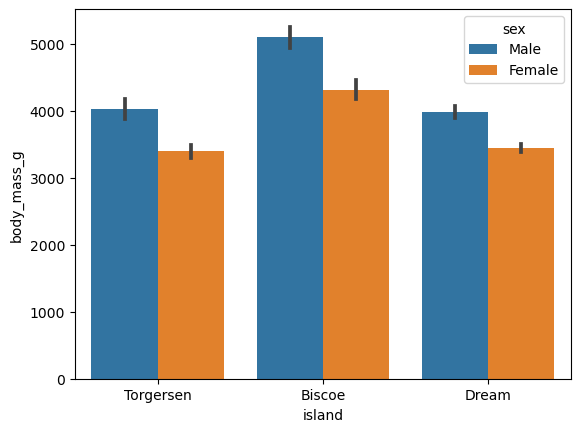

In [5]:
df = sns.load_dataset("penguins")
sns.barplot(data=df, x="island", y="body_mass_g", hue="sex")

In [4]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
